In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain
import datetime as dt
from scipy.stats import gaussian_kde

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pdm_functions as fns

In [2]:
print("Current working directory:", os.getcwd())

Current working directory: C:\SK\ai_proj\data_analysis


In [3]:
df_waveform = pd.read_csv('dataset/wave_5528')

In [4]:
df_label = pd.read_csv('dataset/status_hist_5528')

In [5]:
print(type(df_waveform)); print(df_waveform.info())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2862 entries, 0 to 2861
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   asset_id         2862 non-null   object
 1   created_at       2862 non-null   int64 
 2   waveform_x       2862 non-null   object
 3   waveform_y       2862 non-null   object
 4   waveform_z       2862 non-null   object
 5   spectrum_x_amp   2862 non-null   object
 6   spectrum_x_freq  2862 non-null   object
 7   spectrum_y_amp   2862 non-null   object
 8   spectrum_y_freq  2862 non-null   object
 9   spectrum_z_amp   2862 non-null   object
 10  spectrum_z_freq  2862 non-null   object
dtypes: int64(1), object(10)
memory usage: 246.1+ KB
None


In [6]:
print(df_label.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   asset_id             238 non-null    object 
 1   time                 238 non-null    object 
 2   imbalance_health     210 non-null    float64
 3   misalignment_health  210 non-null    float64
 4   looseness_health     210 non-null    float64
 5   bearing_health       210 non-null    float64
 6   asset_health         219 non-null    float64
 7   CRT_DT               238 non-null    object 
dtypes: float64(5), object(3)
memory usage: 15.0+ KB
None


## Convert Unix to Datetime

In [7]:
df_label['time'] = pd.to_datetime(df_label['time'] )

In [8]:
df_label['time']

0     2024-01-02
1     2024-01-05
2     2024-01-01
3     2024-01-03
4     2024-01-04
         ...    
233   2024-08-18
234   2024-08-26
235   2024-08-24
236   2024-08-23
237   2024-08-25
Name: time, Length: 238, dtype: datetime64[ns]

In [9]:
df_waveform['created_at'] = pd.to_datetime(df_waveform['created_at'], unit = 's').dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul').dt.date
df_waveform['created_at'] = pd.to_datetime(df_waveform['created_at'])
df_waveform['created_at']

0      2024-01-01
1      2024-01-01
2      2024-01-01
3      2024-01-01
4      2024-01-01
          ...    
2857   2024-08-26
2858   2024-08-26
2859   2024-08-26
2860   2024-08-26
2861   2024-08-26
Name: created_at, Length: 2862, dtype: datetime64[ns]

## Concatenating Health to Waveform

In [10]:
df_waveform = df_waveform.drop(columns=['asset_id', 'spectrum_x_amp', 'spectrum_x_freq', 'spectrum_y_amp', 'spectrum_y_freq', 'spectrum_z_amp', 'spectrum_z_freq'])
df_waveform

,created_at,waveform_x,waveform_y,waveform_z
0,2024-01-01,"0,0.005859375,0.017578125,0,0,0.005859375,-0.0...","-0.087890625,-0.05859375,-0.0703125,-0.0644531...","0.955078125,0.9375,0.9375,0.955078125,0.955078..."
1,2024-01-01,"0,0.017578125,-0.017578125,0,0.029296875,0.023...","-0.064453125,-0.08203125,-0.076171875,-0.06445...","0.9609375,0.931640625,0.966796875,0.984375,0.9..."
2,2024-01-01,"0,0.017578125,0,0.017578125,0,0.017578125,0,0,...","-0.029296875,-0.10546875,-0.064453125,-0.07031...","0.97265625,0.94921875,0.990234375,0.9375,0.966..."
3,2024-01-01,"0,0.017578125,0,0,0,0.041015625,0.0234375,0.00...","-0.052734375,-0.0703125,-0.076171875,-0.070312...","0.92578125,0.990234375,0.9375,0.97265625,0.937..."
4,2024-01-01,"0.017578125,-0.041015625,0,-0.03515625,0.09375...","-0.1640625,0.0234375,0.029296875,-0.1875,-0.16...","0.931640625,0.966796875,1.072265625,0.81445312..."
...,...,...,...,...
2857,2024-08-26,"-0.029296875,-0.029296875,0,0,-0.0234375,0.011...","-0.0703125,-0.041015625,-0.05859375,-0.09375,-...","0.9375,0.896484375,0.966796875,0.931640625,0.9..."
2858,2024-08-26,"-0.15234375,0.228515625,-0.08203125,-0.1992187...","-0.287109375,0.041015625,-0.181640625,-0.19921...","1.154296875,0.97265625,0.69140625,1.125,0.8906..."
2859,2024-08-26,"-0.123046875,-0.416015625,0.251953125,0.140625...","-0.029296875,-0.755859375,0.181640625,0.369140...","0.4453125,0.896484375,1.294921875,1.037109375,..."
2860,2024-08-26,"0.046875,-0.1640625,0,-0.169921875,-0.15234375...","-0.375,-0.046875,0.08203125,-0.392578125,-0.06...","0.837890625,0.896484375,0.873046875,0.87890625..."


In [11]:
df_label = df_label[['time', 'imbalance_health']]

In [12]:
df_label = df_label.dropna(subset=['imbalance_health'])
df_label

,time,imbalance_health
8,2024-01-10,0.924009
10,2024-01-11,1.000000
11,2024-01-13,1.000000
12,2024-01-12,1.000000
13,2024-01-14,0.878773
...,...,...
233,2024-08-18,1.000000
234,2024-08-26,1.000000
235,2024-08-24,1.000000
236,2024-08-23,1.000000


In [13]:
df = pd.merge(df_waveform, df_label, how='inner', left_on = 'created_at', right_on = 'time')
df 

,created_at,waveform_x,waveform_y,waveform_z,time,imbalance_health
0,2024-01-10,"0.01171875,0.0234375,-0.0234375,0,0,-0.0175781...","-0.064453125,-0.1171875,-0.05859375,-0.0761718...","0.9375,0.94921875,0.9140625,0.9375,0.90234375,...",2024-01-10,0.924009
1,2024-01-10,"-0.029296875,0.123046875,0,0,-0.08203125,0.076...","-0.0703125,-0.01171875,-0.10546875,-0.04101562...","0.9140625,0.890625,0.919921875,1.03125,0.9375,...",2024-01-10,0.924009
2,2024-01-10,"0,0,0,0,0,0,0,0.017578125,0.01171875,0.0117187...","-0.064453125,-0.087890625,-0.064453125,-0.0761...","0.9375,0.9609375,0.931640625,0.9140625,0.96093...",2024-01-10,0.924009
3,2024-01-10,"0,-0.01171875,0.005859375,0.005859375,0.005859...","-0.05859375,-0.076171875,-0.076171875,-0.07617...","0.9609375,0.955078125,0.94921875,0.97265625,0....",2024-01-10,0.924009
4,2024-01-10,"-0.33984375,0.31640625,0,-0.2578125,0.45703125...","0.005859375,-0.509765625,0.22265625,-0.0175781...","1.013671875,0.849609375,0.75,1.18359375,1.1367...",2024-01-10,0.924009
...,...,...,...,...,...,...
2508,2024-08-26,"-0.029296875,-0.029296875,0,0,-0.0234375,0.011...","-0.0703125,-0.041015625,-0.05859375,-0.09375,-...","0.9375,0.896484375,0.966796875,0.931640625,0.9...",2024-08-26,1.000000
2509,2024-08-26,"-0.15234375,0.228515625,-0.08203125,-0.1992187...","-0.287109375,0.041015625,-0.181640625,-0.19921...","1.154296875,0.97265625,0.69140625,1.125,0.8906...",2024-08-26,1.000000
2510,2024-08-26,"-0.123046875,-0.416015625,0.251953125,0.140625...","-0.029296875,-0.755859375,0.181640625,0.369140...","0.4453125,0.896484375,1.294921875,1.037109375,...",2024-08-26,1.000000
2511,2024-08-26,"0.046875,-0.1640625,0,-0.169921875,-0.15234375...","-0.375,-0.046875,0.08203125,-0.392578125,-0.06...","0.837890625,0.896484375,0.873046875,0.87890625...",2024-08-26,1.000000


In [14]:
# df_waveform = df_waveform[df_waveform['created_at'].isin(df_label['time'])]
# # df_wave = df_wave[df_wave['time'].isin(df_label['time'])]
# df_waveform

## Filtering normal data

In [15]:
df_normal = df[df['imbalance_health'] == float(1)]
df_normal

,created_at,waveform_x,waveform_y,waveform_z,time,imbalance_health
13,2024-01-11,"0.0234375,0,-0.005859375,0,0,0.01171875,0,0,0,...","-0.076171875,-0.076171875,-0.046875,-0.0644531...","0.931640625,0.931640625,0.943359375,0.9375,0.9...",2024-01-11,1.0
14,2024-01-11,"0,-0.017578125,0,0,0.0234375,-0.005859375,-0.0...","-0.076171875,-0.076171875,-0.076171875,-0.0468...","0.978515625,0.966796875,0.931640625,0.93164062...",2024-01-11,1.0
15,2024-01-11,"0,0.0234375,0,-0.017578125,0.017578125,0,0,0,0...","-0.05859375,-0.08203125,-0.08203125,-0.0644531...","0.931640625,0.9375,0.97265625,0.99609375,0.937...",2024-01-11,1.0
16,2024-01-11,"0.005859375,0,0.005859375,0,0,-0.03515625,0,0....","-0.076171875,-0.10546875,-0.0703125,-0.0761718...","0.943359375,0.99609375,0.9375,0.9609375,0.9667...",2024-01-11,1.0
17,2024-01-11,"0.134765625,0.2109375,-0.38671875,0,0.15234375...","0.216796875,0.10546875,-0.234375,-0.1875,0.193...","1.32421875,0.9375,0.65625,0.9609375,1.01953125...",2024-01-11,1.0
...,...,...,...,...,...,...
2508,2024-08-26,"-0.029296875,-0.029296875,0,0,-0.0234375,0.011...","-0.0703125,-0.041015625,-0.05859375,-0.09375,-...","0.9375,0.896484375,0.966796875,0.931640625,0.9...",2024-08-26,1.0
2509,2024-08-26,"-0.15234375,0.228515625,-0.08203125,-0.1992187...","-0.287109375,0.041015625,-0.181640625,-0.19921...","1.154296875,0.97265625,0.69140625,1.125,0.8906...",2024-08-26,1.0
2510,2024-08-26,"-0.123046875,-0.416015625,0.251953125,0.140625...","-0.029296875,-0.755859375,0.181640625,0.369140...","0.4453125,0.896484375,1.294921875,1.037109375,...",2024-08-26,1.0
2511,2024-08-26,"0.046875,-0.1640625,0,-0.169921875,-0.15234375...","-0.375,-0.046875,0.08203125,-0.392578125,-0.06...","0.837890625,0.896484375,0.873046875,0.87890625...",2024-08-26,1.0


In [16]:
df_error = df[df['imbalance_health'] != float(1)]
df_error

,created_at,waveform_x,waveform_y,waveform_z,time,imbalance_health
0,2024-01-10,"0.01171875,0.0234375,-0.0234375,0,0,-0.0175781...","-0.064453125,-0.1171875,-0.05859375,-0.0761718...","0.9375,0.94921875,0.9140625,0.9375,0.90234375,...",2024-01-10,0.924009
1,2024-01-10,"-0.029296875,0.123046875,0,0,-0.08203125,0.076...","-0.0703125,-0.01171875,-0.10546875,-0.04101562...","0.9140625,0.890625,0.919921875,1.03125,0.9375,...",2024-01-10,0.924009
2,2024-01-10,"0,0,0,0,0,0,0,0.017578125,0.01171875,0.0117187...","-0.064453125,-0.087890625,-0.064453125,-0.0761...","0.9375,0.9609375,0.931640625,0.9140625,0.96093...",2024-01-10,0.924009
3,2024-01-10,"0,-0.01171875,0.005859375,0.005859375,0.005859...","-0.05859375,-0.076171875,-0.076171875,-0.07617...","0.9609375,0.955078125,0.94921875,0.97265625,0....",2024-01-10,0.924009
4,2024-01-10,"-0.33984375,0.31640625,0,-0.2578125,0.45703125...","0.005859375,-0.509765625,0.22265625,-0.0175781...","1.013671875,0.849609375,0.75,1.18359375,1.1367...",2024-01-10,0.924009
...,...,...,...,...,...,...
2186,2024-07-26,"0,0,-0.0234375,0,0,-0.0234375,-0.0234375,0,-0....","-0.09375,-0.10546875,-0.08203125,-0.09375,-0.0...","0.943359375,0.919921875,0.9140625,0.978515625,...",2024-07-26,0.981797
2187,2024-07-26,"0.345703125,-0.03515625,-0.251953125,0.140625,...","0.24609375,-0.064453125,-0.31640625,0.06445312...","0.814453125,1.04296875,0.955078125,0.9140625,0...",2024-07-26,0.981797
2188,2024-07-26,"-0.03515625,-0.029296875,0.029296875,-0.017578...","-0.099609375,-0.0703125,-0.046875,-0.1171875,-...","0.90234375,0.9375,0.943359375,0.890625,0.93164...",2024-07-26,0.981797
2189,2024-07-26,"0.017578125,-0.181640625,0.140625,-0.0234375,0...","-0.029296875,0.12890625,-0.01171875,-0.234375,...","0.8671875,0.76171875,1.01953125,1.060546875,0....",2024-07-26,0.981797


In [17]:
df_normal_x = df_normal['waveform_x']
df_normal_y = df_normal['waveform_y']
df_normal_z = df_normal['waveform_z']

df_normal_x

13      0.0234375,0,-0.005859375,0,0,0.01171875,0,0,0,...
14      0,-0.017578125,0,0,0.0234375,-0.005859375,-0.0...
15      0,0.0234375,0,-0.017578125,0.017578125,0,0,0,0...
16      0.005859375,0,0.005859375,0,0,-0.03515625,0,0....
17      0.134765625,0.2109375,-0.38671875,0,0.15234375...
                              ...                        
2508    -0.029296875,-0.029296875,0,0,-0.0234375,0.011...
2509    -0.15234375,0.228515625,-0.08203125,-0.1992187...
2510    -0.123046875,-0.416015625,0.251953125,0.140625...
2511    0.046875,-0.1640625,0,-0.169921875,-0.15234375...
2512    0.01171875,-0.052734375,0,0.005859375,0,0.0058...
Name: waveform_x, Length: 2309, dtype: object

In [18]:
df_normal_x = df_normal_x.apply(lambda x: [float(num) for num in x.split(',')])
df_normal_y = df_normal_y.apply(lambda x: [float(num) for num in x.split(',')])
df_normal_z = df_normal_z.apply(lambda x: [float(num) for num in x.split(',')])

In [19]:
print(df_normal_x); print(type(df_normal_x.iloc[0])); print(type(df_normal_x.iloc[0][9])); print(len(df_normal_x.iloc[0]))

13      [0.0234375, 0.0, -0.005859375, 0.0, 0.0, 0.011...
14      [0.0, -0.017578125, 0.0, 0.0, 0.0234375, -0.00...
15      [0.0, 0.0234375, 0.0, -0.017578125, 0.01757812...
16      [0.005859375, 0.0, 0.005859375, 0.0, 0.0, -0.0...
17      [0.134765625, 0.2109375, -0.38671875, 0.0, 0.1...
                              ...                        
2508    [-0.029296875, -0.029296875, 0.0, 0.0, -0.0234...
2509    [-0.15234375, 0.228515625, -0.08203125, -0.199...
2510    [-0.123046875, -0.416015625, 0.251953125, 0.14...
2511    [0.046875, -0.1640625, 0.0, -0.169921875, -0.1...
2512    [0.01171875, -0.052734375, 0.0, 0.005859375, 0...
Name: waveform_x, Length: 2309, dtype: object
<class 'list'>
<class 'float'>
3200


## Analysing WaveForm

In [20]:
w1 = df_normal_x.iloc[0]
print(sum(num > 0 for num in w1))
print(sum(num < 0 for num in w1))
print(sum(num == 0 for num in w1))

859
705
1636


## Revolution Function
### This will not work because it does not seem to possible to get revolution from waveform data since it does not guarantee that it has peaks.     

In [21]:
# def get_revolution(waveform): 
#     cross_num = 0
#     for i in range(len(waveform)-1): 
        


## Get Dominant Frequency from Spectrum Data

In [32]:
df_normal = pd.read_csv('dataset/5528_spec_normal.csv')
df_error = pd.read_csv('dataset/5528_spec_error.csv')


In [23]:
# df_normal.info(), df_error.info()

In [24]:
# df_normal.head(), df_error.head()

In [25]:
# print(type(df_normal['spectrum_x_amp'].iloc[0]))

### X Spectrum

In [33]:
df_normal['spectrum_x_amp']= df_normal['spectrum_x_amp'].apply(lambda x: [float(num) for num in x.split(',')][1:])
df_error['spectrum_x_amp']= df_error['spectrum_x_amp'].apply(lambda x: [float(num) for num in x.split(',')])[1:]

In [27]:
len(df_normal['spectrum_x_amp'][0])

2048

In [30]:
df_normal['spectrum_x_amp']

0       [0.0006416402772945482, 0.0006967116032034175,...
1       [0.00046743998424794654, 0.0002757226016452911...
2       [0.00028399929256615647, 0.0003624820057698942...
3       [6.886010749249397e-05, 0.00015660348397942753...
4       [0.0013137867109838262, 0.002479297796449496, ...
                              ...                        
2143    [0.00019601150211220783, 0.0002110699028518240...
2144    [0.00013065276184553336, 8.733154273262023e-05...
2145    [0.00011971222976955133, 0.0003781453419813549...
2146    [0.00015052913262383972, 0.0001496677730241791...
2147    [0.00017276590450038444, 0.0002325345318056139...
Name: spectrum_x_amp, Length: 2148, dtype: object

KeyError: 'spectrum_x_amp'

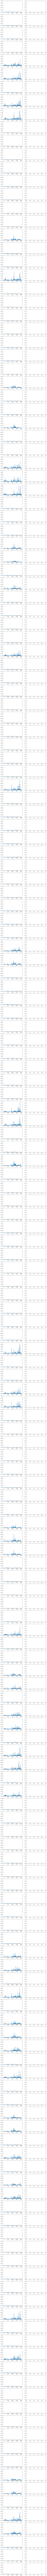

In [31]:
fig, axes = plt.subplots(nrows = 192, ncols = 2, figsize= (10, 600))
for i in range(192): 
    axes[i,0].plot(df_normal['spectrum_x_amp'][i])
    axes[i,0].set_ylim(0, 0.1)
for j in range(192):
    axes[j,1].plot(df_error['spectrum_x_amp'][j])
    axes[j,1].set_ylim(0, 0.1)
plt.savefig('all_errors_graph.png')
plt.show()
    

In [146]:
df_normal_max_index = pd.Series(df_normal['spectrum_x_amp'].apply(lambda x: x.index(max(x))
                                                                  if max(x) >= 0.02 else 0))
df_normal_max_index

0          0
1          0
2          0
3          0
4       1880
        ... 
2143       0
2144       0
2145       0
2146       0
2147       0
Name: spectrum_x_amp, Length: 2148, dtype: int64

In [147]:
df_normal_max_index = df_normal_max_index[df_normal_max_index != 0]

<Axes: ylabel='spectrum_x_amp'>

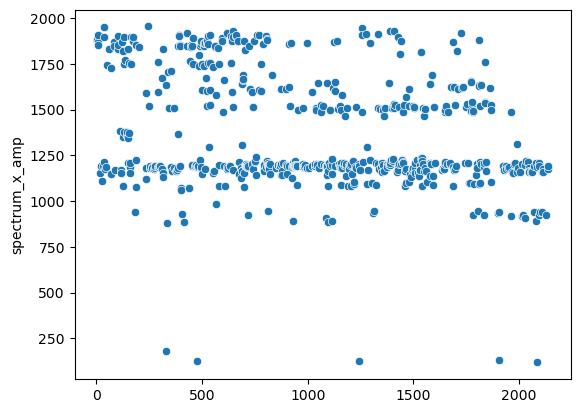

In [148]:
sns.scatterplot(df_normal_max_index)

In [149]:
np.mean(df_normal_max_index), np.median(df_normal_max_index)

(1358.6381909547738, 1203.0)

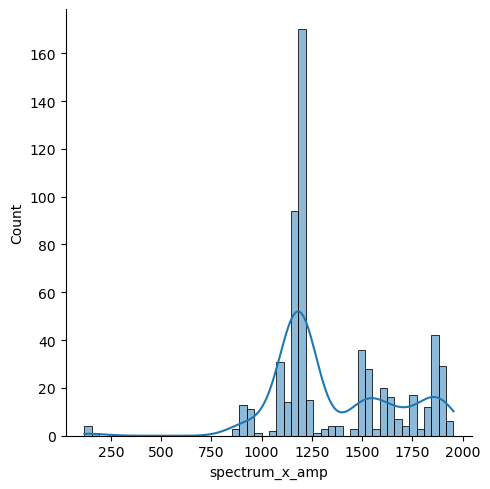

In [150]:
sns.displot(df_normal_max_index, bins=50, kde=True)

In [151]:
spec_freq = [0.78125,1.5625,2.34375,3.125,3.90625,4.6875,5.46875,6.25,7.03125,7.8125,8.59375,9.375,10.15625,10.9375,11.71875,12.5,13.28125,14.0625,14.84375,15.625,16.40625,17.1875,17.96875,18.75,19.53125,20.3125,21.09375,21.875,22.65625,23.4375,24.21875,25,25.78125,26.5625,27.34375,28.125,28.90625,29.6875,30.46875,31.25,32.03125,32.8125,33.59375,34.375,35.15625,35.9375,36.71875,37.5,38.28125,39.0625,39.84375,40.625,41.40625,42.1875,42.96875,43.75,44.53125,45.3125,46.09375,46.875,47.65625,48.4375,49.21875,50,50.78125,51.5625,52.34375,53.125,53.90625,54.6875,55.46875,56.25,57.03125,57.8125,58.59375,59.375,60.15625,60.9375,61.71875,62.5,63.28125,64.0625,64.84375,65.625,66.40625,67.1875,67.96875,68.75,69.53125,70.3125,71.09375,71.875,72.65625,73.4375,74.21875,75,75.78125,76.5625,77.34375,78.125,78.90625,79.6875,80.46875,81.25,82.03125,82.8125,83.59375,84.375,85.15625,85.9375,86.71875,87.5,88.28125,89.0625,89.84375,90.625,91.40625,92.1875,92.96875,93.75,94.53125,95.3125,96.09375,96.875,97.65625,98.4375,99.21875,100,100.78125,101.5625,102.34375,103.125,103.90625,104.6875,105.46875,106.25,107.03125,107.8125,108.59375,109.375,110.15625,110.9375,111.71875,112.5,113.28125,114.0625,114.84375,115.625,116.40625,117.1875,117.96875,118.75,119.53125,120.3125,121.09375,121.875,122.65625,123.4375,124.21875,125,125.78125,126.5625,127.34375,128.125,128.90625,129.6875,130.46875,131.25,132.03125,132.8125,133.59375,134.375,135.15625,135.9375,136.71875,137.5,138.28125,139.0625,139.84375,140.625,141.40625,142.1875,142.96875,143.75,144.53125,145.3125,146.09375,146.875,147.65625,148.4375,149.21875,150,150.78125,151.5625,152.34375,153.125,153.90625,154.6875,155.46875,156.25,157.03125,157.8125,158.59375,159.375,160.15625,160.9375,161.71875,162.5,163.28125,164.0625,164.84375,165.625,166.40625,167.1875,167.96875,168.75,169.53125,170.3125,171.09375,171.875,172.65625,173.4375,174.21875,175,175.78125,176.5625,177.34375,178.125,178.90625,179.6875,180.46875,181.25,182.03125,182.8125,183.59375,184.375,185.15625,185.9375,186.71875,187.5,188.28125,189.0625,189.84375,190.625,191.40625,192.1875,192.96875,193.75,194.53125,195.3125,196.09375,196.875,197.65625,198.4375,199.21875,200,200.78125,201.5625,202.34375,203.125,203.90625,204.6875,205.46875,206.25,207.03125,207.8125,208.59375,209.375,210.15625,210.9375,211.71875,212.5,213.28125,214.0625,214.84375,215.625,216.40625,217.1875,217.96875,218.75,219.53125,220.3125,221.09375,221.875,222.65625,223.4375,224.21875,225,225.78125,226.5625,227.34375,228.125,228.90625,229.6875,230.46875,231.25,232.03125,232.8125,233.59375,234.375,235.15625,235.9375,236.71875,237.5,238.28125,239.0625,239.84375,240.625,241.40625,242.1875,242.96875,243.75,244.53125,245.3125,246.09375,246.875,247.65625,248.4375,249.21875,250,250.78125,251.5625,252.34375,253.125,253.90625,254.6875,255.46875,256.25,257.03125,257.8125,258.59375,259.375,260.15625,260.9375,261.71875,262.5,263.28125,264.0625,264.84375,265.625,266.40625,267.1875,267.96875,268.75,269.53125,270.3125,271.09375,271.875,272.65625,273.4375,274.21875,275,275.78125,276.5625,277.34375,278.125,278.90625,279.6875,280.46875,281.25,282.03125,282.8125,283.59375,284.375,285.15625,285.9375,286.71875,287.5,288.28125,289.0625,289.84375,290.625,291.40625,292.1875,292.96875,293.75,294.53125,295.3125,296.09375,296.875,297.65625,298.4375,299.21875,300,300.78125,301.5625,302.34375,303.125,303.90625,304.6875,305.46875,306.25,307.03125,307.8125,308.59375,309.375,310.15625,310.9375,311.71875,312.5,313.28125,314.0625,314.84375,315.625,316.40625,317.1875,317.96875,318.75,319.53125,320.3125,321.09375,321.875,322.65625,323.4375,324.21875,325,325.78125,326.5625,327.34375,328.125,328.90625,329.6875,330.46875,331.25,332.03125,332.8125,333.59375,334.375,335.15625,335.9375,336.71875,337.5,338.28125,339.0625,339.84375,340.625,341.40625,342.1875,342.96875,343.75,344.53125,345.3125,346.09375,346.875,347.65625,348.4375,349.21875,350,350.78125,351.5625,352.34375,353.125,353.90625,354.6875,355.46875,356.25,357.03125,357.8125,358.59375,359.375,360.15625,360.9375,361.71875,362.5,363.28125,364.0625,364.84375,365.625,366.40625,367.1875,367.96875,368.75,369.53125,370.3125,371.09375,371.875,372.65625,373.4375,374.21875,375,375.78125,376.5625,377.34375,378.125,378.90625,379.6875,380.46875,381.25,382.03125,382.8125,383.59375,384.375,385.15625,385.9375,386.71875,387.5,388.28125,389.0625,389.84375,390.625,391.40625,392.1875,392.96875,393.75,394.53125,395.3125,396.09375,396.875,397.65625,398.4375,399.21875,400,400.78125,401.5625,402.34375,403.125,403.90625,404.6875,405.46875,406.25,407.03125,407.8125,408.59375,409.375,410.15625,410.9375,411.71875,412.5,413.28125,414.0625,414.84375,415.625,416.40625,417.1875,417.96875,418.75,419.53125,420.3125,421.09375,421.875,422.65625,423.4375,424.21875,425,425.78125,426.5625,427.34375,428.125,428.90625,429.6875,430.46875,431.25,432.03125,432.8125,433.59375,434.375,435.15625,435.9375,436.71875,437.5,438.28125,439.0625,439.84375,440.625,441.40625,442.1875,442.96875,443.75,444.53125,445.3125,446.09375,446.875,447.65625,448.4375,449.21875,450,450.78125,451.5625,452.34375,453.125,453.90625,454.6875,455.46875,456.25,457.03125,457.8125,458.59375,459.375,460.15625,460.9375,461.71875,462.5,463.28125,464.0625,464.84375,465.625,466.40625,467.1875,467.96875,468.75,469.53125,470.3125,471.09375,471.875,472.65625,473.4375,474.21875,475,475.78125,476.5625,477.34375,478.125,478.90625,479.6875,480.46875,481.25,482.03125,482.8125,483.59375,484.375,485.15625,485.9375,486.71875,487.5,488.28125,489.0625,489.84375,490.625,491.40625,492.1875,492.96875,493.75,494.53125,495.3125,496.09375,496.875,497.65625,498.4375,499.21875,500,500.78125,501.5625,502.34375,503.125,503.90625,504.6875,505.46875,506.25,507.03125,507.8125,508.59375,509.375,510.15625,510.9375,511.71875,512.5,513.28125,514.0625,514.84375,515.625,516.40625,517.1875,517.96875,518.75,519.53125,520.3125,521.09375,521.875,522.65625,523.4375,524.21875,525,525.78125,526.5625,527.34375,528.125,528.90625,529.6875,530.46875,531.25,532.03125,532.8125,533.59375,534.375,535.15625,535.9375,536.71875,537.5,538.28125,539.0625,539.84375,540.625,541.40625,542.1875,542.96875,543.75,544.53125,545.3125,546.09375,546.875,547.65625,548.4375,549.21875,550,550.78125,551.5625,552.34375,553.125,553.90625,554.6875,555.46875,556.25,557.03125,557.8125,558.59375,559.375,560.15625,560.9375,561.71875,562.5,563.28125,564.0625,564.84375,565.625,566.40625,567.1875,567.96875,568.75,569.53125,570.3125,571.09375,571.875,572.65625,573.4375,574.21875,575,575.78125,576.5625,577.34375,578.125,578.90625,579.6875,580.46875,581.25,582.03125,582.8125,583.59375,584.375,585.15625,585.9375,586.71875,587.5,588.28125,589.0625,589.84375,590.625,591.40625,592.1875,592.96875,593.75,594.53125,595.3125,596.09375,596.875,597.65625,598.4375,599.21875,600,600.78125,601.5625,602.34375,603.125,603.90625,604.6875,605.46875,606.25,607.03125,607.8125,608.59375,609.375,610.15625,610.9375,611.71875,612.5,613.28125,614.0625,614.84375,615.625,616.40625,617.1875,617.96875,618.75,619.53125,620.3125,621.09375,621.875,622.65625,623.4375,624.21875,625,625.78125,626.5625,627.34375,628.125,628.90625,629.6875,630.46875,631.25,632.03125,632.8125,633.59375,634.375,635.15625,635.9375,636.71875,637.5,638.28125,639.0625,639.84375,640.625,641.40625,642.1875,642.96875,643.75,644.53125,645.3125,646.09375,646.875,647.65625,648.4375,649.21875,650,650.78125,651.5625,652.34375,653.125,653.90625,654.6875,655.46875,656.25,657.03125,657.8125,658.59375,659.375,660.15625,660.9375,661.71875,662.5,663.28125,664.0625,664.84375,665.625,666.40625,667.1875,667.96875,668.75,669.53125,670.3125,671.09375,671.875,672.65625,673.4375,674.21875,675,675.78125,676.5625,677.34375,678.125,678.90625,679.6875,680.46875,681.25,682.03125,682.8125,683.59375,684.375,685.15625,685.9375,686.71875,687.5,688.28125,689.0625,689.84375,690.625,691.40625,692.1875,692.96875,693.75,694.53125,695.3125,696.09375,696.875,697.65625,698.4375,699.21875,700,700.78125,701.5625,702.34375,703.125,703.90625,704.6875,705.46875,706.25,707.03125,707.8125,708.59375,709.375,710.15625,710.9375,711.71875,712.5,713.28125,714.0625,714.84375,715.625,716.40625,717.1875,717.96875,718.75,719.53125,720.3125,721.09375,721.875,722.65625,723.4375,724.21875,725,725.78125,726.5625,727.34375,728.125,728.90625,729.6875,730.46875,731.25,732.03125,732.8125,733.59375,734.375,735.15625,735.9375,736.71875,737.5,738.28125,739.0625,739.84375,740.625,741.40625,742.1875,742.96875,743.75,744.53125,745.3125,746.09375,746.875,747.65625,748.4375,749.21875,750,750.78125,751.5625,752.34375,753.125,753.90625,754.6875,755.46875,756.25,757.03125,757.8125,758.59375,759.375,760.15625,760.9375,761.71875,762.5,763.28125,764.0625,764.84375,765.625,766.40625,767.1875,767.96875,768.75,769.53125,770.3125,771.09375,771.875,772.65625,773.4375,774.21875,775,775.78125,776.5625,777.34375,778.125,778.90625,779.6875,780.46875,781.25,782.03125,782.8125,783.59375,784.375,785.15625,785.9375,786.71875,787.5,788.28125,789.0625,789.84375,790.625,791.40625,792.1875,792.96875,793.75,794.53125,795.3125,796.09375,796.875,797.65625,798.4375,799.21875,800,800.78125,801.5625,802.34375,803.125,803.90625,804.6875,805.46875,806.25,807.03125,807.8125,808.59375,809.375,810.15625,810.9375,811.71875,812.5,813.28125,814.0625,814.84375,815.625,816.40625,817.1875,817.96875,818.75,819.53125,820.3125,821.09375,821.875,822.65625,823.4375,824.21875,825,825.78125,826.5625,827.34375,828.125,828.90625,829.6875,830.46875,831.25,832.03125,832.8125,833.59375,834.375,835.15625,835.9375,836.71875,837.5,838.28125,839.0625,839.84375,840.625,841.40625,842.1875,842.96875,843.75,844.53125,845.3125,846.09375,846.875,847.65625,848.4375,849.21875,850,850.78125,851.5625,852.34375,853.125,853.90625,854.6875,855.46875,856.25,857.03125,857.8125,858.59375,859.375,860.15625,860.9375,861.71875,862.5,863.28125,864.0625,864.84375,865.625,866.40625,867.1875,867.96875,868.75,869.53125,870.3125,871.09375,871.875,872.65625,873.4375,874.21875,875,875.78125,876.5625,877.34375,878.125,878.90625,879.6875,880.46875,881.25,882.03125,882.8125,883.59375,884.375,885.15625,885.9375,886.71875,887.5,888.28125,889.0625,889.84375,890.625,891.40625,892.1875,892.96875,893.75,894.53125,895.3125,896.09375,896.875,897.65625,898.4375,899.21875,900,900.78125,901.5625,902.34375,903.125,903.90625,904.6875,905.46875,906.25,907.03125,907.8125,908.59375,909.375,910.15625,910.9375,911.71875,912.5,913.28125,914.0625,914.84375,915.625,916.40625,917.1875,917.96875,918.75,919.53125,920.3125,921.09375,921.875,922.65625,923.4375,924.21875,925,925.78125,926.5625,927.34375,928.125,928.90625,929.6875,930.46875,931.25,932.03125,932.8125,933.59375,934.375,935.15625,935.9375,936.71875,937.5,938.28125,939.0625,939.84375,940.625,941.40625,942.1875,942.96875,943.75,944.53125,945.3125,946.09375,946.875,947.65625,948.4375,949.21875,950,950.78125,951.5625,952.34375,953.125,953.90625,954.6875,955.46875,956.25,957.03125,957.8125,958.59375,959.375,960.15625,960.9375,961.71875,962.5,963.28125,964.0625,964.84375,965.625,966.40625,967.1875,967.96875,968.75,969.53125,970.3125,971.09375,971.875,972.65625,973.4375,974.21875,975,975.78125,976.5625,977.34375,978.125,978.90625,979.6875,980.46875,981.25,982.03125,982.8125,983.59375,984.375,985.15625,985.9375,986.71875,987.5,988.28125,989.0625,989.84375,990.625,991.40625,992.1875,992.96875,993.75,994.53125,995.3125,996.09375,996.875,997.65625,998.4375,999.21875,1000,1000.78125,1001.5625,1002.34375,1003.125,1003.90625,1004.6875,1005.46875,1006.25,1007.03125,1007.8125,1008.59375,1009.375,1010.15625,1010.9375,1011.71875,1012.5,1013.28125,1014.0625,1014.84375,1015.625,1016.40625,1017.1875,1017.96875,1018.75,1019.53125,1020.3125,1021.09375,1021.875,1022.65625,1023.4375,1024.21875,1025,1025.78125,1026.5625,1027.34375,1028.125,1028.90625,1029.6875,1030.46875,1031.25,1032.03125,1032.8125,1033.59375,1034.375,1035.15625,1035.9375,1036.71875,1037.5,1038.28125,1039.0625,1039.84375,1040.625,1041.40625,1042.1875,1042.96875,1043.75,1044.53125,1045.3125,1046.09375,1046.875,1047.65625,1048.4375,1049.21875,1050,1050.78125,1051.5625,1052.34375,1053.125,1053.90625,1054.6875,1055.46875,1056.25,1057.03125,1057.8125,1058.59375,1059.375,1060.15625,1060.9375,1061.71875,1062.5,1063.28125,1064.0625,1064.84375,1065.625,1066.40625,1067.1875,1067.96875,1068.75,1069.53125,1070.3125,1071.09375,1071.875,1072.65625,1073.4375,1074.21875,1075,1075.78125,1076.5625,1077.34375,1078.125,1078.90625,1079.6875,1080.46875,1081.25,1082.03125,1082.8125,1083.59375,1084.375,1085.15625,1085.9375,1086.71875,1087.5,1088.28125,1089.0625,1089.84375,1090.625,1091.40625,1092.1875,1092.96875,1093.75,1094.53125,1095.3125,1096.09375,1096.875,1097.65625,1098.4375,1099.21875,1100,1100.78125,1101.5625,1102.34375,1103.125,1103.90625,1104.6875,1105.46875,1106.25,1107.03125,1107.8125,1108.59375,1109.375,1110.15625,1110.9375,1111.71875,1112.5,1113.28125,1114.0625,1114.84375,1115.625,1116.40625,1117.1875,1117.96875,1118.75,1119.53125,1120.3125,1121.09375,1121.875,1122.65625,1123.4375,1124.21875,1125,1125.78125,1126.5625,1127.34375,1128.125,1128.90625,1129.6875,1130.46875,1131.25,1132.03125,1132.8125,1133.59375,1134.375,1135.15625,1135.9375,1136.71875,1137.5,1138.28125,1139.0625,1139.84375,1140.625,1141.40625,1142.1875,1142.96875,1143.75,1144.53125,1145.3125,1146.09375,1146.875,1147.65625,1148.4375,1149.21875,1150,1150.78125,1151.5625,1152.34375,1153.125,1153.90625,1154.6875,1155.46875,1156.25,1157.03125,1157.8125,1158.59375,1159.375,1160.15625,1160.9375,1161.71875,1162.5,1163.28125,1164.0625,1164.84375,1165.625,1166.40625,1167.1875,1167.96875,1168.75,1169.53125,1170.3125,1171.09375,1171.875,1172.65625,1173.4375,1174.21875,1175,1175.78125,1176.5625,1177.34375,1178.125,1178.90625,1179.6875,1180.46875,1181.25,1182.03125,1182.8125,1183.59375,1184.375,1185.15625,1185.9375,1186.71875,1187.5,1188.28125,1189.0625,1189.84375,1190.625,1191.40625,1192.1875,1192.96875,1193.75,1194.53125,1195.3125,1196.09375,1196.875,1197.65625,1198.4375,1199.21875,1200,1200.78125,1201.5625,1202.34375,1203.125,1203.90625,1204.6875,1205.46875,1206.25,1207.03125,1207.8125,1208.59375,1209.375,1210.15625,1210.9375,1211.71875,1212.5,1213.28125,1214.0625,1214.84375,1215.625,1216.40625,1217.1875,1217.96875,1218.75,1219.53125,1220.3125,1221.09375,1221.875,1222.65625,1223.4375,1224.21875,1225,1225.78125,1226.5625,1227.34375,1228.125,1228.90625,1229.6875,1230.46875,1231.25,1232.03125,1232.8125,1233.59375,1234.375,1235.15625,1235.9375,1236.71875,1237.5,1238.28125,1239.0625,1239.84375,1240.625,1241.40625,1242.1875,1242.96875,1243.75,1244.53125,1245.3125,1246.09375,1246.875,1247.65625,1248.4375,1249.21875,1250,1250.78125,1251.5625,1252.34375,1253.125,1253.90625,1254.6875,1255.46875,1256.25,1257.03125,1257.8125,1258.59375,1259.375,1260.15625,1260.9375,1261.71875,1262.5,1263.28125,1264.0625,1264.84375,1265.625,1266.40625,1267.1875,1267.96875,1268.75,1269.53125,1270.3125,1271.09375,1271.875,1272.65625,1273.4375,1274.21875,1275,1275.78125,1276.5625,1277.34375,1278.125,1278.90625,1279.6875,1280.46875,1281.25,1282.03125,1282.8125,1283.59375,1284.375,1285.15625,1285.9375,1286.71875,1287.5,1288.28125,1289.0625,1289.84375,1290.625,1291.40625,1292.1875,1292.96875,1293.75,1294.53125,1295.3125,1296.09375,1296.875,1297.65625,1298.4375,1299.21875,1300,1300.78125,1301.5625,1302.34375,1303.125,1303.90625,1304.6875,1305.46875,1306.25,1307.03125,1307.8125,1308.59375,1309.375,1310.15625,1310.9375,1311.71875,1312.5,1313.28125,1314.0625,1314.84375,1315.625,1316.40625,1317.1875,1317.96875,1318.75,1319.53125,1320.3125,1321.09375,1321.875,1322.65625,1323.4375,1324.21875,1325,1325.78125,1326.5625,1327.34375,1328.125,1328.90625,1329.6875,1330.46875,1331.25,1332.03125,1332.8125,1333.59375,1334.375,1335.15625,1335.9375,1336.71875,1337.5,1338.28125,1339.0625,1339.84375,1340.625,1341.40625,1342.1875,1342.96875,1343.75,1344.53125,1345.3125,1346.09375,1346.875,1347.65625,1348.4375,1349.21875,1350,1350.78125,1351.5625,1352.34375,1353.125,1353.90625,1354.6875,1355.46875,1356.25,1357.03125,1357.8125,1358.59375,1359.375,1360.15625,1360.9375,1361.71875,1362.5,1363.28125,1364.0625,1364.84375,1365.625,1366.40625,1367.1875,1367.96875,1368.75,1369.53125,1370.3125,1371.09375,1371.875,1372.65625,1373.4375,1374.21875,1375,1375.78125,1376.5625,1377.34375,1378.125,1378.90625,1379.6875,1380.46875,1381.25,1382.03125,1382.8125,1383.59375,1384.375,1385.15625,1385.9375,1386.71875,1387.5,1388.28125,1389.0625,1389.84375,1390.625,1391.40625,1392.1875,1392.96875,1393.75,1394.53125,1395.3125,1396.09375,1396.875,1397.65625,1398.4375,1399.21875,1400,1400.78125,1401.5625,1402.34375,1403.125,1403.90625,1404.6875,1405.46875,1406.25,1407.03125,1407.8125,1408.59375,1409.375,1410.15625,1410.9375,1411.71875,1412.5,1413.28125,1414.0625,1414.84375,1415.625,1416.40625,1417.1875,1417.96875,1418.75,1419.53125,1420.3125,1421.09375,1421.875,1422.65625,1423.4375,1424.21875,1425,1425.78125,1426.5625,1427.34375,1428.125,1428.90625,1429.6875,1430.46875,1431.25,1432.03125,1432.8125,1433.59375,1434.375,1435.15625,1435.9375,1436.71875,1437.5,1438.28125,1439.0625,1439.84375,1440.625,1441.40625,1442.1875,1442.96875,1443.75,1444.53125,1445.3125,1446.09375,1446.875,1447.65625,1448.4375,1449.21875,1450,1450.78125,1451.5625,1452.34375,1453.125,1453.90625,1454.6875,1455.46875,1456.25,1457.03125,1457.8125,1458.59375,1459.375,1460.15625,1460.9375,1461.71875,1462.5,1463.28125,1464.0625,1464.84375,1465.625,1466.40625,1467.1875,1467.96875,1468.75,1469.53125,1470.3125,1471.09375,1471.875,1472.65625,1473.4375,1474.21875,1475,1475.78125,1476.5625,1477.34375,1478.125,1478.90625,1479.6875,1480.46875,1481.25,1482.03125,1482.8125,1483.59375,1484.375,1485.15625,1485.9375,1486.71875,1487.5,1488.28125,1489.0625,1489.84375,1490.625,1491.40625,1492.1875,1492.96875,1493.75,1494.53125,1495.3125,1496.09375,1496.875,1497.65625,1498.4375,1499.21875,1500,1500.78125,1501.5625,1502.34375,1503.125,1503.90625,1504.6875,1505.46875,1506.25,1507.03125,1507.8125,1508.59375,1509.375,1510.15625,1510.9375,1511.71875,1512.5,1513.28125,1514.0625,1514.84375,1515.625,1516.40625,1517.1875,1517.96875,1518.75,1519.53125,1520.3125,1521.09375,1521.875,1522.65625,1523.4375,1524.21875,1525,1525.78125,1526.5625,1527.34375,1528.125,1528.90625,1529.6875,1530.46875,1531.25,1532.03125,1532.8125,1533.59375,1534.375,1535.15625,1535.9375,1536.71875,1537.5,1538.28125,1539.0625,1539.84375,1540.625,1541.40625,1542.1875,1542.96875,1543.75,1544.53125,1545.3125,1546.09375,1546.875,1547.65625,1548.4375,1549.21875,1550,1550.78125,1551.5625,1552.34375,1553.125,1553.90625,1554.6875,1555.46875,1556.25,1557.03125,1557.8125,1558.59375,1559.375,1560.15625,1560.9375,1561.71875,1562.5,1563.28125,1564.0625,1564.84375,1565.625,1566.40625,1567.1875,1567.96875,1568.75,1569.53125,1570.3125,1571.09375,1571.875,1572.65625,1573.4375,1574.21875,1575,1575.78125,1576.5625,1577.34375,1578.125,1578.90625,1579.6875,1580.46875,1581.25,1582.03125,1582.8125,1583.59375,1584.375,1585.15625,1585.9375,1586.71875,1587.5,1588.28125,1589.0625,1589.84375,1590.625,1591.40625,1592.1875,1592.96875,1593.75,1594.53125,1595.3125,1596.09375,1596.875,1597.65625,1598.4375,1599.21875,1600]
print(spec_freq[1358]); print(len(spec_freq))

1061.71875
2048


In [152]:
print(max(df_normal_max_index), len(df_normal_max_index))

1954 597


### Y Spectrum

In [35]:
# df_normal['spectrum_y_amp']= df_normal['spectrum_y_amp'].apply(lambda x: [float(num) for num in x.split(',')])
# df_error['spectrum_y_amp']= df_error['spectrum_y_amp'].apply(lambda x: [float(num) for num in x.split(',')])

# df_normal_max_index = pd.Series(df_normal['spectrum_y_amp'].apply(lambda x: 
#                                                                   x.index(max(x)) if max(x) >= 0.02 else 0))

# df_normal_max_index = df_normal_max_index_x[df_normal_max_index != 0]

# np.mean(df_normal_max_index), np.median(df_normal_max_index)

In [36]:
# sns.scatterplot(df_normal_max_index)

In [37]:
# sns.displot(df_normal_max_index, bins=50)

### Z Spectrum

In [38]:
# df_normal['spectrum_z_amp']= df_normal['spectrum_z_amp'].apply(lambda x: [float(num) for num in x.split(',')])
# df_error['spectrum_z_amp']= df_error['spectrum_z_amp'].apply(lambda x: [float(num) for num in x.split(',')])

# df_normal_max_index = pd.Series(df_normal['spectrum_z_amp'].apply(lambda x: 
#                                                                   x.index(max(x)) if max(x) >= 0.02 else 0))

# df_normal_max_index = df_normal_max_index_x[df_normal_max_index != 0]

# np.mean(df_normal_max_index), np.median(df_normal_max_index)

In [39]:
# sns.scatterplot(df_normal_max_index)

In [40]:
# sns.displot(df_normal_max_index, bins=50)

## Weighted Function (KDE) 

In [157]:
print(max(df_normal_max_index), len(df_normal_max_index));
print(df_normal_max_index, type(df_normal_max_index))

1954 597
4       1880
5       1870
7       1907
8       1854
17      1156
        ... 
2111    1173
2114    1158
2126     922
2137    1177
2138    1192
Name: spectrum_x_amp, Length: 597, dtype: int64 <class 'pandas.core.series.Series'>


In [70]:
def rpm_approx_weighted_fn(df_normal_max_index, x_val_min, x_val_max, num_linspace): 
    """ approximating rpm from dominant amplitude on frequency domain
    parameters:
    df_spectrum(pands Series) 

    return:
    """
    # df_max_index = pd.Series(df_spectrum['spectrum_x_amp'].apply(lambda x: 
    #                                                               x.index(max(x)) if max(x) >= 0.02 else 0))
    # df_max_index = df_max_index[df_max_index != 0]

    kde = gaussian_kde(df_normal_max_index)
    kde_values = kde(np.linspace(x_val_min, x_val_max, num_linspace)) 
    kde_values_list = kde_values.tolist()

    return kde_values_list
    

<Axes: >

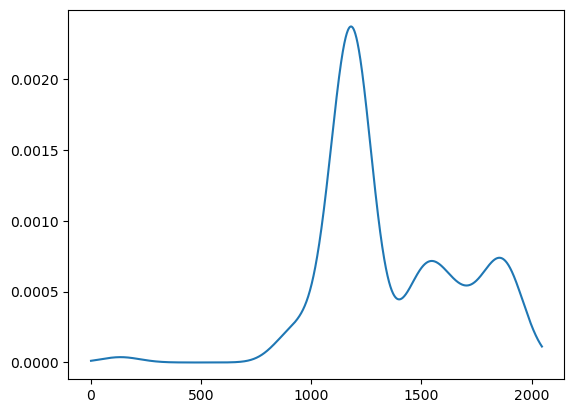

In [158]:
test = rpm_approx_weighted_fn(df_normal_max_index,  1, 2048, 2048 )
sns.lineplot(test)

In [82]:
test[-10:]

[0.000680726647189304,
 0.0006796087121322781,
 0.0006784798307720989,
 0.0006773403097581656,
 0.0006761904559989581,
 0.0006750305766043704,
 0.0006738609788292054,
 0.0006726819700178371,
 0.0006714938575500232,
 0.0006702969487878976]

In [ ]:
max

In [42]:
# kde = gaussian_kde(df_normal_max_index)
# kde_values = kde(np.linspace(df_normal_max_index.min(), df_normal_max_index.max(), 2048)) 

In [43]:
# kde_values_list = kde_values.tolist()

In [44]:
# plt.plot(spec_freq, kde_values_list, label='KDE', color='red')

In [45]:
# def rpm_approx_weighted_fn(df_spectrum, x_val_min, x_val_max, num_linspace): 
#     """ approximating rpm from dominant amplitude on frequency domain
#     parameters:
#     df_spectrum(pands Series) 

#     return:
#     """
#     df_max_index = pd.Series(df_spectrum['spectrum_x_amp'].apply(lambda x: 
#                                                                   x.index(max(x)) if max(x) >= 0.02 else 0))
#     df_max_index = df_max_index[df_max_index != 0]

#     kde = gaussian_kde(df_max_index)
#     kde_values = kde(np.linspace(x_val_min, x_val_max, num_linspace)) 
#     kde_values_list = kde_values.tolist()

#     return kde_values_list
    

In [159]:
kde_val = fns.rpm_approx_weighted_fn(df_normal['spectrum_x_amp'], 1, 2048, 2048)

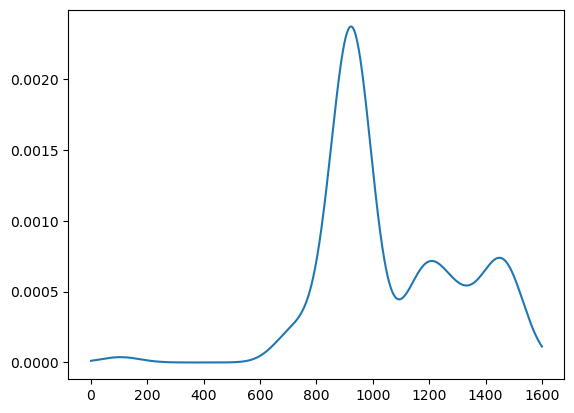

In [160]:
plt.plot(spec_freq, kde_val)

In [161]:
len(kde_val)

2048

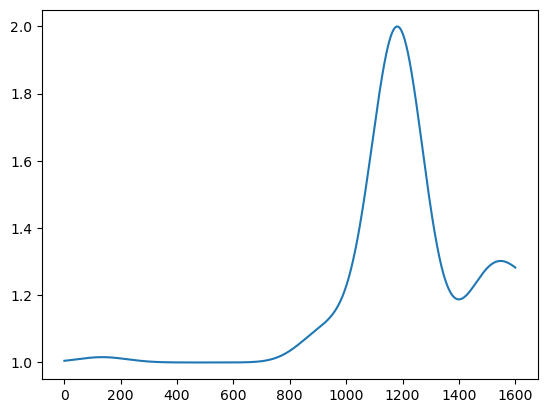

In [48]:
plt.plot(spec_freq, fns.min_max_standardization(kde_val,maxval=2))